In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
from dateutil.parser import parse
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

sns.set_style("whitegrid")

In [2]:
# Import the sales training data

training_df = pd.read_csv('sales_train_v2.csv')
training_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


 ### Since the date column is in weird format, we'll be working to convert the column into a readable format. In particular, we'll be converting the current format ('DD.MM.YYYY') to the new format ('YYYY-MM-DD') so that we can organize the data better.

In [3]:
# Make a function that changes the format of the date string to a more organized style

def fix_date_format(date):
    '''Changes format from DD.MM.YYYY to YYYY-MM-DD'''
    return (date[-4:] + '-' + date[3:5] + '-' + date[:2])

In [4]:
# Apply the defined function to convert the dates into readable format

training_df['date'] = training_df['date'].apply(fix_date_format)
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [5]:
# Convert all the dates into datetime objects for easier analysis

datetime_conversion = pd.to_datetime(training_df['date'])
training_df['date'] = datetime_conversion
# training_df['date'] = datetime_conversion.dt.to_period('M')

training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


### Here we'll import the rest of the data. For training, we won't be working with the test or sample datas.

In [6]:
# Import the items dataset
items_df = pd.read_csv('items.csv')

# Import the item_categories.csv dataset with the item_category_id as the index
items_cat_df = pd.read_csv('item_categories.csv', index_col = 'item_category_id')

# Import the shops.csv dataset with the shop_id as the index
shops_df = pd.read_csv('shops.csv', index_col = 'shop_id')

# Import the test.csv dataset with the ID as the index
test = pd.read_csv('test.csv', index_col = 'ID')

# Import the sample_submission.csv dataset with the ID as the index
sample = pd.read_csv('sample_submission.csv', index_col = 'ID')

In [7]:
sample.head()

,item_cnt_month
ID,
0,0.5
1,0.5
2,0.5
3,0.5
4,0.5


In [8]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


Let's explore some of the datasets to make sure there are no null values and missing values. If there are any, we'll go ahead and clean that up.

In [9]:
items_df.isnull().nunique()

item_name           1
item_id             1
item_category_id    1
dtype: int64

In [10]:
items_cat_df.isnull().nunique()

item_category_name    1
dtype: int64

In [11]:
shops_df.isnull().nunique()

shop_name    1
dtype: int64

There aren't any null values, but we also need to check for any weird inputs in the dataset.

In [12]:
training_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [13]:
training_df.sort_values('item_price', ascending=False).head()
# For the purpose of this data, we'll remove the entry at the max item_price (307,980).

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0
885138,2013-09-17,8,12,11365,59200.0,1.0
1488135,2014-03-20,14,25,13199,50999.0,1.0
2327159,2015-01-29,24,12,7241,49782.0,1.0
2931380,2015-10-20,33,22,13403,42990.0,1.0


In [14]:
training_df = training_df[training_df['item_price'] != 307980.0]

In [15]:
# It appears like there is are negative values in item_price and item_cnt_day. Let's take a closer look at those
training_df.sort_values('item_price', ascending=True).head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0000,1.0
608763,2013-06-08,5,58,11865,0.0700,1.0
579766,2013-06-11,5,6,11864,0.0700,1.0
611400,2013-06-08,5,58,20146,0.0875,4.0
673155,2013-07-31,6,6,11872,0.0900,1.0


In [16]:
training_df[training_df['item_cnt_day'] < 0].sort_values('item_cnt_day').head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1057907,2013-11-02,10,12,8023,15.000000,-22.0
1835454,2014-07-10,18,14,20949,5.000000,-16.0
2048519,2014-10-10,21,12,9242,1433.333333,-9.0
59156,2013-01-18,0,12,1590,2599.000000,-6.0
940092,2013-10-19,9,42,3732,2599.000000,-6.0


In [17]:
training_df[training_df['item_cnt_day'] < 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7356 entries, 2 to 2935779
Data columns (total 6 columns):
date              7356 non-null datetime64[ns]
date_block_num    7356 non-null int64
shop_id           7356 non-null int64
item_id           7356 non-null int64
item_price        7356 non-null float64
item_cnt_day      7356 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 402.3 KB


Taking a closer look at the data we see that there is only a single occurence where item_price is less than 0. We can comfortably remove this datapoint from our analysis as it seems unrealistic to sell items at a negative price and this is likely a mistake.

Taking a look at item_cnt_day, we see there are 7356 datapoints where there are negative values for item_cnt_day. Although this is only a small portion of nearly 3 million datapoints, we'll go ahead and try out analysis with and without these values.

In [18]:
# Create a cleaned training data without the negative item_price and item_cnt_day
no_negative_df = training_df[(training_df['item_price'] >= 0) & (training_df['item_cnt_day'] >= 0)]

# Create another cleaned training data without the negative item price and all data for item_cnt_day
half_negative_df = training_df[training_df['item_price'] >= 0]

Let's take a look at both of the new datasets and see if there are any outliers. We'll be doing this with some exploratory data analysis using scatterplots and .describe()

However, first we will need to decide how we want to approach this huge dataset. We want to be able to make predictions for future sales of both the product and the stores. For the Kaggle competition, the purpose was to forcast the total amount of product sales in every shop so we'll start from there.

We'll also start by working with the dataset with all negative values removed.

For my first approach, I'll be looking at the performance of a single shop, then expanding it to all shops. We'll be using a time-series plot for our analysis.

In [19]:
no_negative_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0


In [20]:
# Since there are 21804 unique items, it's not practical to explore the data of each, so we'll try looking at one in detail
# and see how that looks.
no_negative_df.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21803
item_price        19976
item_cnt_day        189
dtype: int64

In [21]:
# Taking a quick look at it, it doesn't seem like an individual item has many datapoints. Let's try looking at item categories.
no_negative_df[no_negative_df['item_id'] == 2552]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1,2013-01-03,0,25,2552,899.0,1.0
375824,2013-04-25,3,6,2552,949.0,1.0
419930,2013-04-25,3,30,2552,949.0,1.0
523067,2013-05-24,4,4,2552,949.0,1.0
679741,2013-07-14,6,22,2552,949.0,1.0
1723811,2014-06-28,17,28,2552,949.0,1.0
2648872,2015-05-27,28,50,2552,949.0,1.0


In [22]:
items_df.head()

# There are a fair amount of Russian characters in the item_name column

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [23]:
items_cat_df.head()

# There are also a lot of Russian characters in the item_category_name column.
# There also doesn't appear to be a distinct formatting for extracting just the English characters.

,item_category_name
item_category_id,
0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2
2,Аксессуары - PS3
3,Аксессуары - PS4
4,Аксессуары - PSP


In [24]:
items_cat_df.nunique()

item_category_name    84
dtype: int64

In [25]:
# It seems by removing all the negative values, we lost 366 (22170-21804) unique item ids. However, we didn't lose any category ids
items_df.nunique()

item_name           22170
item_id             22170
item_category_id       84
dtype: int64

Since the dataset comes from Russian origins, we see a lot of Russian text in both the item names and item category names. For now, I'll leave these two columns out when I merge the tables because I'm limited on methods for translation (Google's Translate API cost a fair amount of money especially for a dataset this large). However, the data will still be understandable as the item id and item category ids are unique. For this, we can exclude the items_cat_df dataset as we don't need to extract the category names. We'll be mainly working with the training data and the items_df.

In [26]:
# Merge the current working training data with items_df so that we can work in item categories
no_negative_merge = no_negative_df.merge(items_df, on='item_id')

# We'll drop the item_name column as it's filled with Russian characters
no_negative_merge.drop('item_name', axis=1, inplace=True)

# Let's take a look at this new dataframe
no_negative_merge.nunique()

date                 1034
date_block_num         34
shop_id                60
item_id             21803
item_price          19976
item_cnt_day          189
item_category_id       84
dtype: int64

In [27]:
no_negative_merge.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,37
1,2013-01-23,0,24,22154,999.0,1.0,37
2,2013-01-20,0,27,22154,999.0,1.0,37
3,2013-01-02,0,25,22154,999.0,1.0,37
4,2013-01-03,0,25,22154,999.0,1.0,37


In [28]:
# Items that aren't sold on a particular day aren't included in the dataset. This should cause an unequal distribution of data
sum(no_negative_merge['item_cnt_day'] == 0.0)

0

In [29]:
# Try exploring the data from shop to shop.

# For this we'll pick a random shop (shop_id = 24) to explore closely
shop_24 = no_negative_merge[no_negative_merge['shop_id'] == 24].groupby('date')['item_cnt_day'].sum()

In [30]:
# With over 1000 datapoints, it might be best to downsample our data to make the data more visible. Since we're working with
# more than 2 years worth of data, we're going to resample it down to monthly for slightly more than 2 dozen datapoints.
# This also makes sense as we're making predictions for an entire month.
resamp_24 = shop_24.resample('M', label='left').sum()

In [31]:
# The x-axis appears a bit shifted to the right because the datapoints are at the end of every month
# So we'll go ahead and explicitly state our x-axis for better visualization
x_label = '2013-01 2013-5 2013-09 2014-01 2014-05 2014-09 2015-01 2015-05 2015-09'.split(' ')
print (x_label)

['2013-01', '2013-5', '2013-09', '2014-01', '2014-05', '2014-09', '2015-01', '2015-05', '2015-09']


Text(0,0.5,'Total items sold monthly')

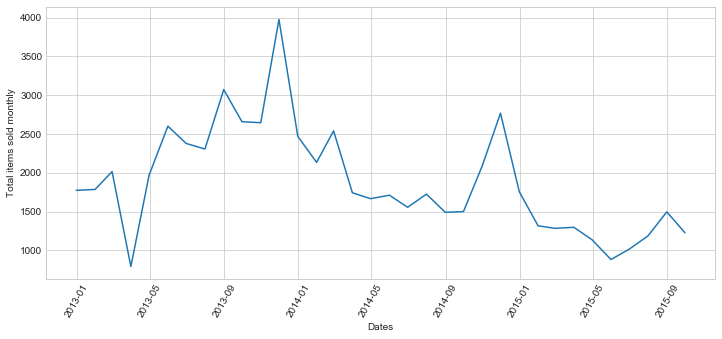

In [32]:
plt.figure(figsize=(12, 5))
plt.plot(resamp_24)
plt.xticks(rotation=60)
plt.xticks(x_label)
plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')

In [33]:
# Let's take a look at another random shop an dsee how it performed.
shop_50 = no_negative_merge[no_negative_merge['shop_id'] == 50].groupby('date')['item_cnt_day'].sum()
resamp_50 = shop_50.resample('M', label='left').sum()

Text(0,0.5,'Total items sold monthly')

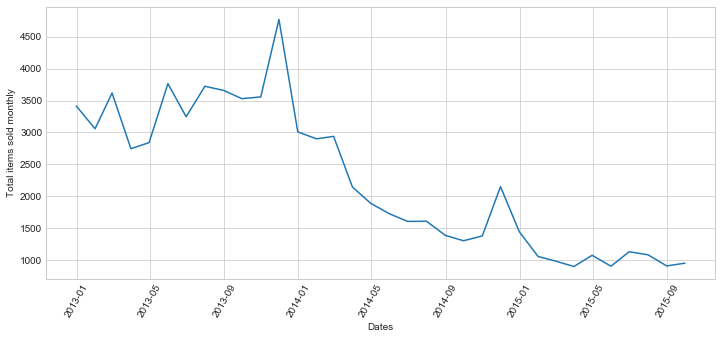

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(resamp_50)
plt.xticks(rotation=60)
plt.xticks(x_label)
plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')

In [35]:
# We'll finish this exploration by looking at another random shop
shop_10 = no_negative_merge[no_negative_merge['shop_id'] == 10].groupby('date')['item_cnt_day'].sum()
resamp_10 = shop_10.resample('M', label='left').sum()

Text(0,0.5,'Total items sold monthly')

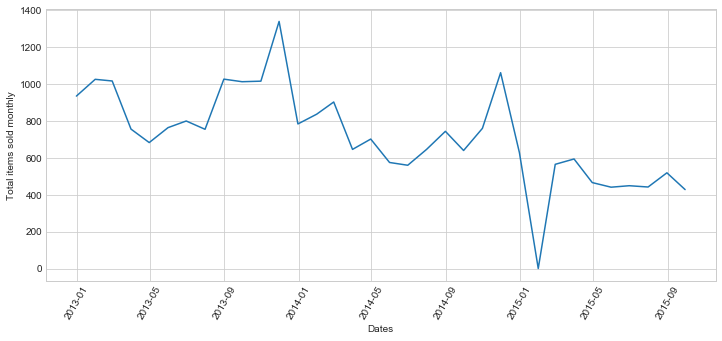

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(resamp_10)
plt.xticks(rotation=60)
plt.xticks(x_label)
plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')

In [37]:
# Create a series that takes the average of the previous 3 charts.
combined_shops = pd.DataFrame([resamp_10, resamp_24, resamp_50]).T
combined_shops.columns = ['shop_10', 'shop_24', 'shop_50']
combined_shops['average'] = combined_shops.mean(axis=1)
#combined_shops['average'] = sum([combined_shops['shop_10'], combined_shops['shop_24'], combined_shops['shop_50']]) / 3

Text(0.5,1,'Total items sold monthly')

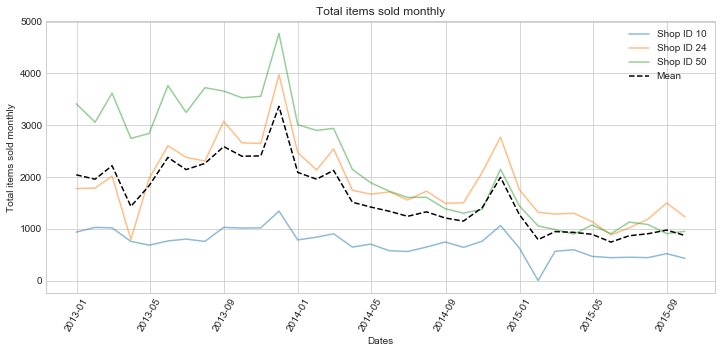

In [38]:
# Let's combine these three plots onto one figure to better visualize the change along with the average
plt.figure(figsize=(12, 5))
plt.plot(resamp_10, alpha=0.5)
plt.plot(resamp_24, alpha=0.5)
plt.plot(resamp_50, alpha=0.5)
plt.plot(combined_shops['average'], c='black', linestyle='--')
plt.legend(['Shop ID 10', 'Shop ID 24', 'Shop ID 50', 'Mean'])
plt.xticks(rotation=60)
plt.xticks(x_label)
plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')
plt.title('Total items sold monthly')

Looking at the three plots, we can see that the performance can differ significantly between all three, but we can see a common sales trend on all 3 plots. Since we're going to be using linear regression to make our predictions, we'll be averaging this data.

In [39]:
# Plot all the shops together. We can do this in two ways: sum all the items sold regardless of shop or group the sales by shops
# and then average them.

In [40]:
# Let's first try it with the sum of all items
sum_shops_df = no_negative_merge.groupby('date')['item_cnt_day'].sum().resample('M', label='left').sum()

Text(0.5,1,'Total items sold across all shops per month')

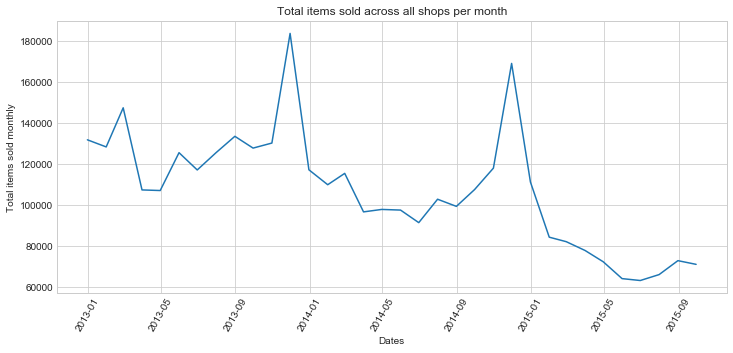

In [41]:
plt.figure(figsize=(12,5))
plt.plot(sum_shops_df)
plt.xticks(rotation=60)
plt.xticks(x_label)
plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')
plt.title('Total items sold across all shops per month')

In [42]:
# Now let's try it with the mean of the groups
mean_shops_df = no_negative_merge.groupby(['date', 
                                           'shop_id'])['item_cnt_day'].sum().groupby('date').mean().resample('M', label='left').sum()

Text(0.5,1,'Average items sold across all shops per month')

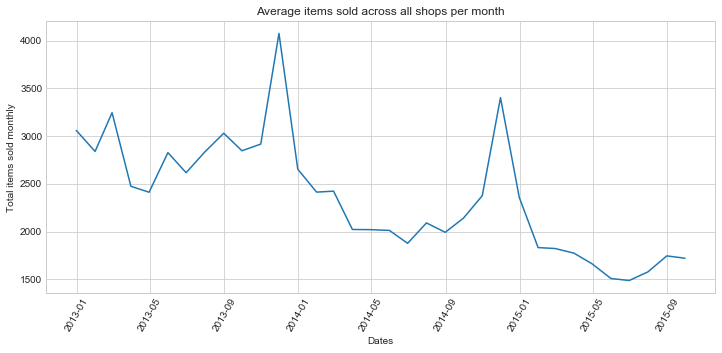

In [43]:
plt.figure(figsize=(12,5))
plt.plot(mean_shops_df)
plt.xticks(rotation=60)
plt.xticks(x_label)
plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')
plt.title('Average items sold across all shops per month')

# The average and total sold appear to share the same patterns, but are shifted differently from the x-axis.

In [44]:
# Check for correlation between total items sold and other variables.

# Let's use a heatmap to observe the correlation between all of the main variables

# plt.figure(figsize=(12, 10))
# sns.heatmap(no_negative_merge[['date_block_num', 'shop_id', 'item_id', 'item_price',
#                              'item_cnt_day', 'item_category_id']], annot=True, cmap = 'coolwarm')

# The use of the heatmap caused the kernel to freeze. We'll do our correlation analysis one at a time.

In [45]:
# Let's use jointplots to observe the correlation between two variables.

# First we'll start with the date_block_num which corresponds to the month. We'll leave an extra category so we keep the df.
date_block_df = no_negative_merge.groupby('date_block_num')['shop_id', 'item_cnt_day'].sum()

# We'll fix the columns so it's less misunderstanding
date_block_df.columns = ['shop_id', 'Totals items sold monthly']

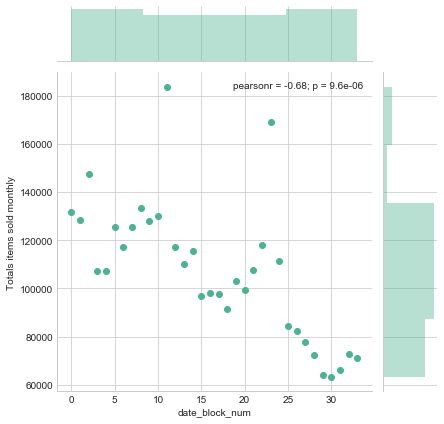

In [46]:
# Plot the data on a jointplot, but shift the x-axis forward by one to make it more readable.
sns.jointplot(x=date_block_df.index, y=date_block_df['Totals items sold monthly'], kind='scatter', color='#4CB391')

# From this scatter plot, we can observe a significant negative trend where stores are selling increasingly less over time.
# However, an interesting point to note are the points on December where there are significant peaks.

Text(0,0.5,'Frequency')

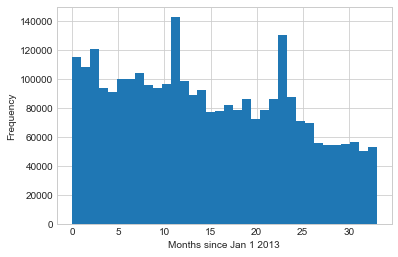

In [47]:
# Let's plot a histogram to see how the purchases are distributed monthly
plt.hist(no_negative_merge['date_block_num'],bins=34)
plt.xlabel('Months since Jan 1 2013')
plt.ylabel('Frequency')

# From the histogram, we can see that the number of entries looks similar to the scatter plot.

In [48]:
# Let's explore the correlation between the shop_id and the items sold.
shop_id_df = no_negative_merge.groupby('shop_id')['item_id', 'item_cnt_day'].sum()

# We'll redefine the columns again
shop_id_df.columns = ['item_id', 'Total items Sold in Shop']

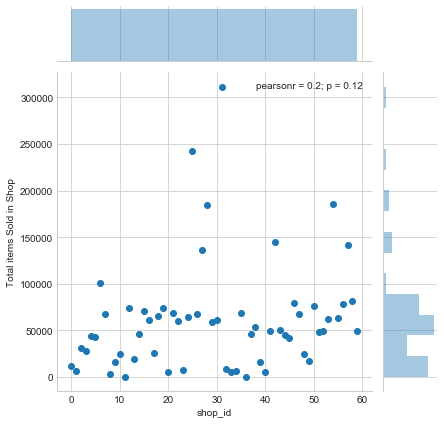

In [49]:
sns.jointplot(x=shop_id_df.index, y=shop_id_df['Total items Sold in Shop'])

# There doesn't appear to be any significant correlation between particular shops and the total items sold. Although
# some shops do perform better than others, this is cannot be a predictor of future performance.

Text(0,0.5,'Frequency')

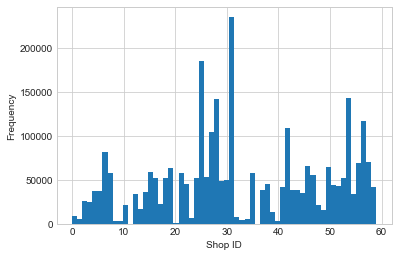

In [50]:
# Let's plot a histogram to see how the purchases are distributed throughout the shops.
plt.hist(x=no_negative_merge['shop_id'], bins=60)
plt.xlabel('Shop ID')
plt.ylabel('Frequency')

# From the looks of the data, (in the span of the 2 years) some shops performed significantly better than others.
# However, we don't have to worry about this as we'll be addressing this with regression towards the mean in our model.

In [51]:
# Let's explore the correlation between the item_category_id and the items sold
# In this case, item_category_id is more reasonable to check than item_id which relay the same information
item_cat_df = no_negative_merge.groupby('item_category_id')['shop_id', 'item_cnt_day'].sum()

item_cat_df.columns = ['shop_id', 'Total items sold in category']

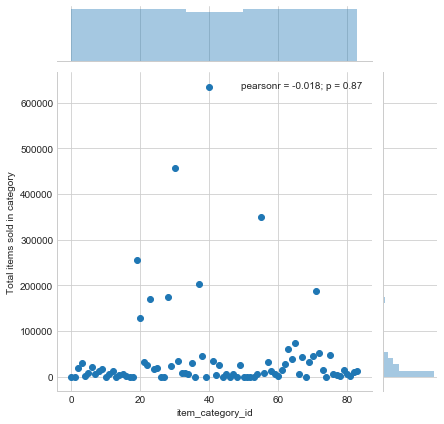

In [52]:
sns.jointplot(x=item_cat_df.index, y=item_cat_df['Total items sold in category'])

# This data appears similar to the data for shop_id. We see most categories sell items on a similar level.
# However, there are certain categories that sell significantly more than others. This would not be a good predictor.

Text(0,0.5,'Frequency')

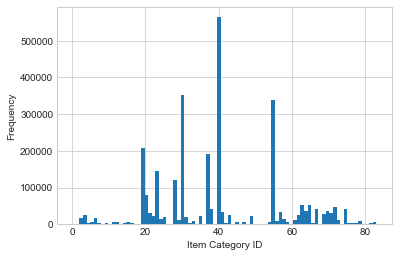

In [53]:
# We'll plot a histogram for this.
plt.hist(no_negative_merge['item_category_id'], bins=84)
plt.xlabel('Item Category ID')
plt.ylabel('Frequency')

# Similar to the distribution for the shop ID, we can see some categories are far more popular than others.

In [54]:
# Lastly, we'll check the correlation between item_price and items sold
item_price_df = no_negative_merge.groupby('item_price')['shop_id', 'item_cnt_day'].sum()

item_price_df.columns = ['shop_id', 'Total Items Sold at Price']

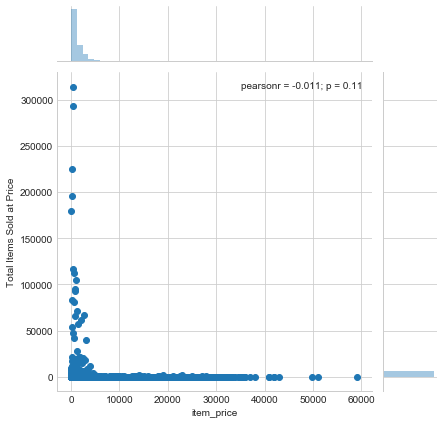

In [55]:
# There is an outlier past item price 300,000, so we'll excluse that in our plot
sns.jointplot(x=item_price_df.index, y=item_price_df['Total Items Sold at Price'])

# Even excluding the outlier at >300000 item price, there doesn't seem to be a general trend for items sold.

Text(0,0.5,'Frequency')

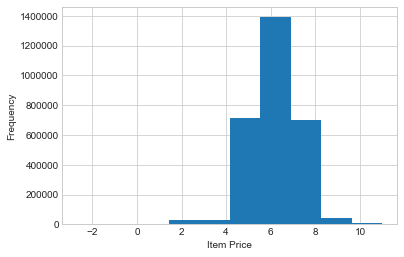

In [56]:
# For this, we'll plot on a logarithmic x-scale to make the data more readble.
plt.hist(np.log(no_negative_merge['item_price']))
plt.xlabel('Item Price')
plt.ylabel('Frequency')

Since we couldn't find any strong variables that can reliably predict the total items per month, we'll keep our linear regression model analysis based on the time of purchasing as well as any variable that makes practical sense to affect the amount of items purchased (item_price and item_category_id). The date and date_block columns are redundant because they relay the same information (time since Jan 1 2013).

In [57]:
# Recall that we're trying to predict how well a specfic item in a specific shop sells  in Nov. 2015.
# As a result, we'll train our data with the item_id and shop_id. We'll also resample our data so that it occurs monthly.

# train_df = no_negative_merge.groupby(['date', 'shop_id', 'item_id'])[['item_cnt_day']].sum()

train_df = no_negative_merge.groupby(['date_block_num', 'shop_id', 'item_id'])[['item_cnt_day']].sum()

# We don't need resample our data since it's already been grouped by date_block_num

In [58]:
train_df.head()

item_cnt_day
date_block_num shop_id item_id              
0              0       32                6.0
                       33                3.0
                       35                1.0
                       43                1.0
                       51                2.0

In [59]:
# final_train = train_df.resample('M').agg({'shop_id':lambda x: x, 'item_id': lambda x:x, 'item_cnt_day':np.sum})
# final_train = train_df.groupby(pd.Grouper(freq='M', level=0))
# final_train = train_df.unstack().T.resample('M').sum().T.stack()

# Let's downsample the data into months
# final_train = train_df.unstack(level=[1,2]).resample('M').sum().stack(level=[1,2])

In [60]:
# final_train.head()

In [61]:
# We'll go ahead set shop_id and item_id back as columns and rename the item_cnt_day
# final_train.reset_index(level=[1,2], inplace=True)
# final_train.columns = ['shop_id', 'item_id', 'item_cnt_month']


# Reset the index so that th edate, shop_id, and item_id are all columns
# final_train.reset_index(inplace=True)
# final_train.columns = ['date', 'shop_id', 'item_id', 'item_cnt_month']

train_df.reset_index(inplace=True)
train_df.columns = ['month', 'shop_id', 'item_id', 'item_cnt_month']

In [62]:
train_df.head()

,month,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [63]:
# Let's check if the created dataframe is correct using a random shop_id and item_id.
# final_train[(final_train['shop_id'] == 32) & (final_train['item_id'] == 30)].head()

# We'll check if our new dataframe is correct
train_df[(train_df['shop_id'] == 32) & (train_df['item_id'] == 30)]

# Recall that month=1 refers to the second month of 2013 which is Feb 2013. We can be confident that this is right.

,month,shop_id,item_id,item_cnt_month
100817,1,32,30,9.0
216593,3,32,30,3.0


In [64]:
no_negative_merge[(no_negative_merge['shop_id'] == 32) & 
                 (no_negative_merge['item_id'] == 30)][['date', 'item_cnt_day']].sort_values('date')

# If we sum up each month, it looks like the created dataframe is correct. (9 in Feb 2013 and 3 in Apr 2013)

,date,item_cnt_day
1239697,2013-02-12,1.0
1239698,2013-02-14,2.0
1239695,2013-02-15,1.0
1239696,2013-02-16,3.0
1239694,2013-02-17,1.0
1239693,2013-02-20,1.0
1240233,2013-04-06,1.0
1240234,2013-04-08,1.0
1240235,2013-04-15,1.0


In [65]:
# Before we set up the linear regression model, we need to fix our dataframe so that we can train our model.

# We need to resample our dates so that there is a single datapoint for each month
# For this, we'll take the sum of the item_cnt_day column, mean of the item_price column, and (???)mode of the item_category_id
# Since item_category_id 40 is the most prevalent one, using the mode isn't appropriate. In that case, we'll remove it from our analysis
# no_negative_merge.head()

In [66]:
# To create a unique dataframe with that many aggregate functions, we'll use the aggfunc
# item_cnt_df = no_negative_merge.groupby('date')['item_cnt_day'].sum().resample('M').sum()
# item_price_df = no_negative_merge.groupby('date')['item_price'].mean().resample('M').mean()
# item_cat_df = no_negative_merge.groupby('date')['item_category_id'].agg(lambda x: x.mode())
# multi_agg_df = no_negative_merge.groupby(['date', 'item_price'])['item_cnt_day'].sum().reset_index(level=1)

In [67]:
# multi_agg_df = multi_agg_df.resample('M').agg({'item_price': np.mean, 'item_cnt_day': np.sum})

In [68]:
# multi_agg_df.head()

In [69]:
# item_cnt_df.head()

In [70]:
# item_price_df.head()

In [71]:
#item_cat_df.head()

In [72]:
# inter_df = pd.concat([item_cnt_df, item_price_df], axis=1)
# inter_df.head()

### It seems like using the statsmodel approach causes the kernel to freeze. We'll try the sklearn approach.

In [73]:
# We'll use statsmodel for our LinearRegression model as it provides a neat table for analysis and it doesn't require making
# separate dataframes with our columns of interest

# from statsmodels.formula.api import ols

In [74]:
# We'll define a quick function that will utilize the statsmodel and return a fitted object

# def linreg_statsmodel(target, variables, data):
#     '''Creates a fitted statsmodel object using provided training data'''
#     formula = (target + ' ~ ')
#     if type(variables) == list:
#         formula += ' + '.join(variables)
#     else:
#         formula += variables
#     return ols(formula, data).fit()

In [75]:
# We'll go ahead create our trained model and check the summary on it with the .summary() function

# trained_ols = linreg_statsmodel('item_cnt_month', ['date', 'shop_id', 'item_id'], final_train)

In [76]:
X = train_df.drop('item_cnt_month', axis=1)#.values
y = train_df['item_cnt_month'].values.reshape(-1, 1)

In [77]:
X.shape

(1608225, 3)

In [78]:
y.shape

(1608225, 1)

In [79]:
trained_linreg = LinearRegression()
trained_linreg.fit(X, train_df['item_cnt_month'])

# LinearRegression can't utilize datetime objects in the analysis. In that case, we'll do our analysis using the date_block_num
# as a replacement for time.

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [80]:
predicted_train_values = trained_linreg.predict(X)

In [81]:
# Let's take a look at the variable coefficients.
pd.DataFrame({'features':X.columns, 'estimatedCoefficients': trained_linreg.coef_})[['features', 'estimatedCoefficients']]

# From the looks of the coefficients, it doesn't look like any of these variables are good predictors

,features,estimatedCoefficients
0,month,0.002208
1,shop_id,0.000229
2,item_id,-0.000015


Text(0,0.5,'Frequency')

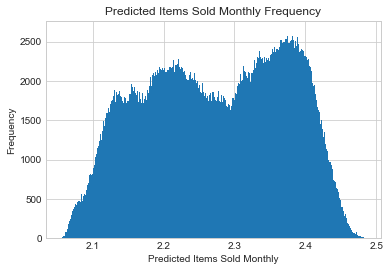

In [82]:
plt.hist(predicted_train_values, bins=1000)
plt.title('Predicted Items Sold Monthly Frequency')
plt.xlabel('Predicted Items Sold Monthly')
plt.ylabel('Frequency')

# This data doesn't appear to be normally distributed. We'll check that quantitatively

In [83]:
print ('Skew:', stats.skew(predicted_train_values))
print ('Kurtosis:', stats.kurtosis(predicted_train_values))

# We can see that there is a left skew along with a multimodal disbritubiton.

Skew: -0.10482469986776957
Kurtosis: -1.1252954830981905


Text(0.5,1,'Original Count vs. Predicted Count')

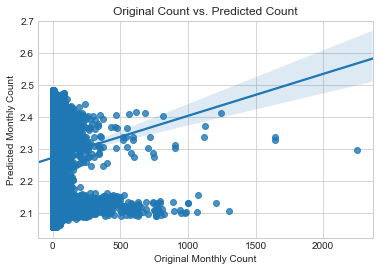

In [84]:
# Let's plot the original count vs. predicted count to visually see how well our model does.
sns.regplot(x=y, y=predicted_train_values)
plt.xlabel('Original Monthly Count')
plt.ylabel('Predicted Monthly Count')
plt.title('Original Count vs. Predicted Count')

In [85]:
# We need to make our values not continous to utilize it in accuracy_score
short_predicted_values = pd.Series(predicted_train_values).apply(lambda x: '{:.4}'.format(x))

In [86]:
# We'll determine the accuracy score of our training data first
print ('Accuracy Score of Model:', accuracy_score(y, short_predicted_values))

# accuracy_score function doesn't work with continous values (the predicted values are continuous)

# Our model is a terrible predictor of the data.

Accuracy Score of Model: 0.0


In [87]:
# Just to test it out, let's use cross validation with this
from sklearn.model_selection import cross_val_score

reg = LinearRegression()

cv_score = cross_val_score(reg, X, y, cv=10)
print (np.mean(cv_score))

-0.0004356230454793164


### Even though we built a very poor model for the data, let's still use it on the test data.

In [88]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [89]:
test['month'] = 34

In [90]:
test.head()

,shop_id,item_id,month
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [91]:
test_y = trained_linreg.predict(test)

In [92]:
test_y[:5]

array([3.56351024, 3.62836437, 3.60842688, 3.60819771, 3.61644771])

By observing the scale of our scatter plot, it is obvious that our model is a poor predictor of performance. However, it is interesting to note that some items performed exceptionally well. Let's take a look at that before we proceed.

In [92]:
train_df.describe()

,month,shop_id,item_id,item_cnt_month
count,1.608225e+06,1.608225e+06,1.608225e+06,1.608225e+06
mean,1.466503e+01,3.280800e+01,1.068148e+04,2.273155e+00
std,9.542386e+00,1.653645e+01,6.238857e+03,8.653238e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,6.000000e+00,2.100000e+01,5.046000e+03,1.000000e+00
50%,1.400000e+01,3.100000e+01,1.049700e+04,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.606000e+04,2.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,2.253000e+03


In [93]:
no_negative_merge.describe()

# The extreme values in our train_df doesn't appear to be fake as we can see similarly high values in the original dataframe.

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.928491e+06,2.928491e+06,2.928491e+06,2.928491e+06,2.928491e+06,2.928491e+06
mean,1.456976e+01,3.300296e+01,1.020028e+04,8.893619e+02,1.248337e+00,4.001635e+01
std,9.422953e+00,1.622543e+01,6.324397e+03,1.718153e+03,2.619586e+00,1.709810e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,1.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.477000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.355000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.569100e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,2.169000e+03,8.300000e+01


### All code past this point attempts to explore the data in a different direction than asked.

In [26]:
# Let's view the spread in item_category_id via boxplots

# First we'll split the data in groups of 30 to make it easier to view.
first_nnm = no_negative_merge[no_negative_merge['item_category_id'] < 30]
second_nnm = no_negative_merge[(no_negative_merge['item_category_id'] < 60) & (no_negative_merge['item_category_id'] >= 30)]
third_nnm = no_negative_merge[(no_negative_merge['item_category_id'] <= 83) & (no_negative_merge['item_category_id'] >= 60)]

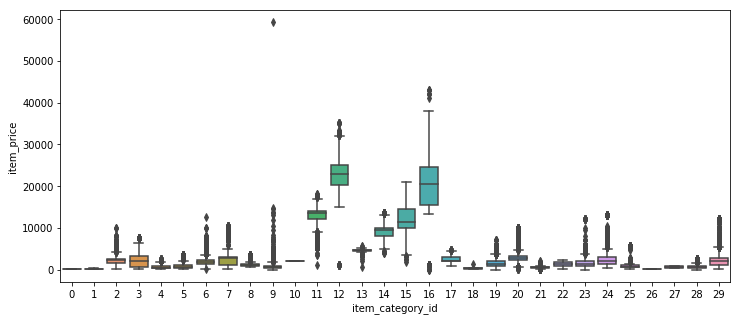

In [27]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='item_category_id', y='item_price', data=first_nnm)
plt.show()

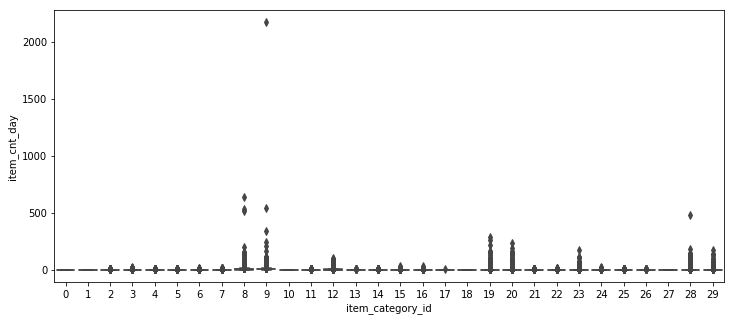

In [28]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='item_category_id', y='item_cnt_day', data=first_nnm)
plt.show()

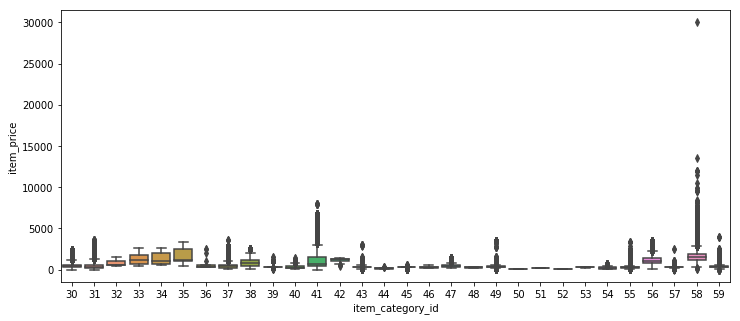

In [29]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='item_category_id', y='item_price', data=second_nnm)
plt.show()

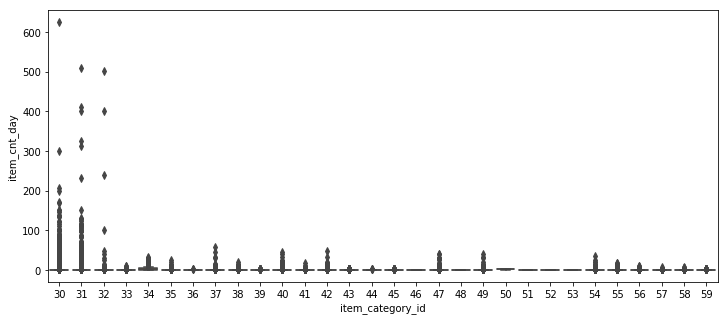

In [30]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='item_category_id', y='item_cnt_day', data=second_nnm)
plt.show()

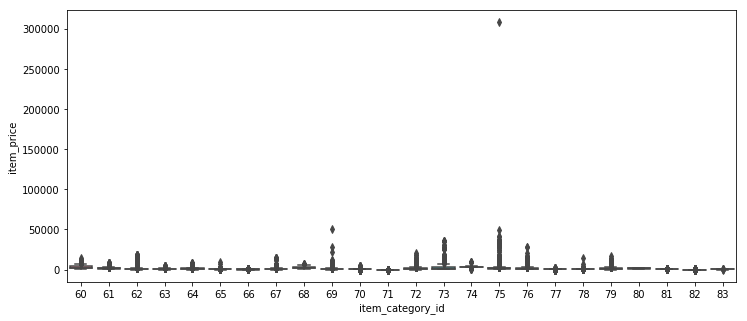

In [31]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='item_category_id', y='item_price', data=third_nnm)
plt.show()

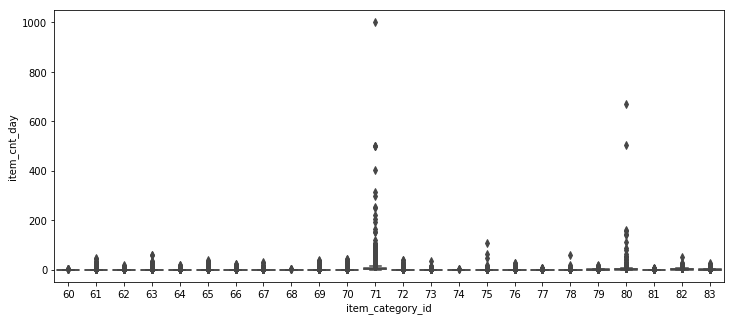

In [32]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='item_category_id', y='item_cnt_day', data=third_nnm)
plt.show()

Taking a quick look at the boxplot spread, we see that there are some pretty strong potential outliers in both item price and items sold that day for each particular category. It may be improper to remove days with the high values for item_cnt_day as those days could be rare cases for holiday sales. 

One way we might want to approach these outliers is simply to deem any values above the 99th percentile as outliers.

In [33]:
# Let's check out all the data within the 99th quantile.
no_negative_merge.quantile([0.25, 0.5, .99])

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0.25,7.0,22.0,4477.0,249.0,1.0,28.0
0.50,14.0,31.0,9355.0,399.0,1.0,40.0
0.99,33.0,59.0,21979.0,5999.0,5.0,76.0


In [34]:
no_negative_merge.max()

# We can see the 99th quantile goes up to 5999.0, whereas the max occurs at 307980

date                2015-10-31 00:00:00
date_block_num                       33
shop_id                              59
item_id                           22169
item_price                       307980
item_cnt_day                       2169
item_category_id                     83
dtype: object

In [35]:
# Let's take a look at this item at the max item_price
no_negative_merge[no_negative_merge['item_price'] == 307980]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
2158309,2013-12-13,11,12,6066,307980.0,1.0,75


In [36]:
# It seems like there was only one of these items ever sold so it's difficult to determine if this is due to human error.
no_negative_merge[no_negative_merge['item_id'] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
2158309,2013-12-13,11,12,6066,307980.0,1.0,75
